## Data Exploration

In [59]:
import data_loader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.set_cmap('RdYlBu')

train, valid = data_loader.load_train_data('dataset/train.csv')
test = data_loader.load_test_data('dataset/test.csv','dataset/test_labels.csv')

train = train.fillna('')
valid = valid.fillna('')
test = test.fillna('')

<Figure size 432x288 with 0 Axes>

In [16]:
print(train.shape)
print(valid.shape)
print(test.shape)

(143645, 8)
(15926, 8)
(63978, 8)


In [18]:
print(train.dtypes)

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


In [21]:
print(train[0:5])

                      id                                       comment_text  \
130060  b7bf5a6846bd456a  "\n Oppose. WP:MOSTM, the guideline covering t...   
132921  c70efd55724be549            === I AM GLEN AND I LOVE BEING A FAG===   
46589   7c7f688f129e511e  "\n\nIf it happens it may be worth noting but ...   
129843  b68d08319e5fcb14        }}\n{{WikiProject Elections and Referendums   
2528    06bf9f58011ca46a  "\n\nI posted a thread about Donny on WP:ANI  ...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
130060      0             0        0       0       0              0  
132921      1             0        0       0       0              0  
46589       0             0        0       0       0              0  
129843      0             0        0       0       0              0  
2528        0             0        0       0       0              0  


In [75]:
# counting frequency of occurence of multi-labelled data
# ct0 -> counts samples with no label
# ct1 -> counts samples having atleast one label
# ct2 -> counts samples having 2 or more than 2 labels
ct0,ct1,ct2 = 0,0,0
label = train[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']]
label = label.as_matrix()
for i in range(label.shape[0]):
    ct = np.count_nonzero(label[i])
    if ct :
        ct1 = ct1+1
    else:
        ct0 = ct0+1
    if ct>1 :
        ct2 = ct2+1
print("Train samples with no label:", ct0)
print("Train samples with atleast one label:", ct1)
print("Train samples with 2 or more labels", ct2)

Train samples with no label: 129006
Train samples with atleast one label: 14639
Train samples with 2 or more labels 8941


In [53]:
# Explore the vocabulary
import collections
from tqdm import tqdm

x_train = train.comment_text.copy()
# Create a counter object for each dataset
word_counter = collections.Counter([word for sentence in tqdm(x_train, total=len(x_train)) \
                                                              for word in sentence.split()])

print('{} words.'.format(len([word for sentence in x_train for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('10 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')

100%|██████████| 143645/143645 [00:01<00:00, 94410.91it/s]


9655027 words.
496117 unique words.
10 Most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


One problem here is that we are counting uppercase words as different from lower case words and a bunch of other symbols that aren't really useful for our goal. A data cleanup will be done in the next step.

average length of comment: 393.746


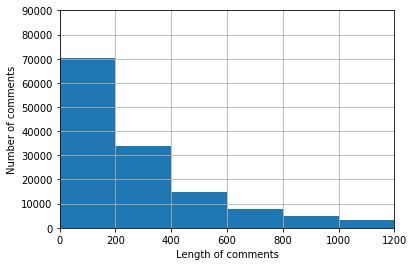

In [76]:
# visualizing the comment size
comment = train['comment_text']
comment = comment.as_matrix()
x = [len(comment[i]) for i in range(comment.shape[0])]
print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

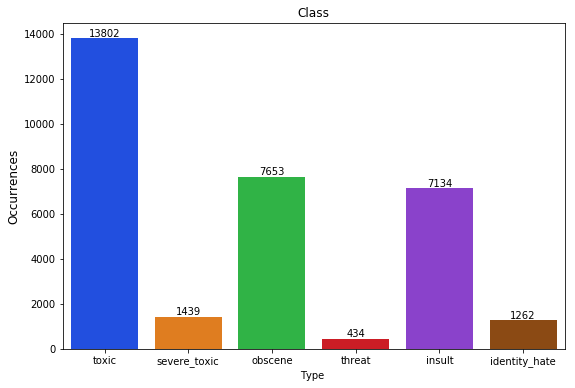

In [66]:
# visualizing the no. of comments of each category
palette= sns.color_palette("bright")
x=train.iloc[:,2:].sum()
plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values, palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

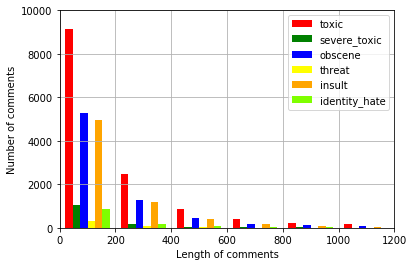

In [80]:
# No. of comments of each type grouped by lengths
y = np.zeros(label.shape)
for ix in range(comment.shape[0]):
    l = len(comment[ix])
    if label[ix][0] :
        y[ix][0] = l
    if label[ix][1] :
        y[ix][1] = l
    if label[ix][2] :
        y[ix][2] = l
    if label[ix][3] :
        y[ix][3] = l
    if label[ix][4] :
        y[ix][4] = l
    if label[ix][5] :
        y[ix][5] = l

labelsplt = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
color = ['red','green','blue','yellow','orange','chartreuse']        
plt.hist(y,bins = bins,label = labelsplt,color = color)
plt.axis([0, 1200, 0, 10000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

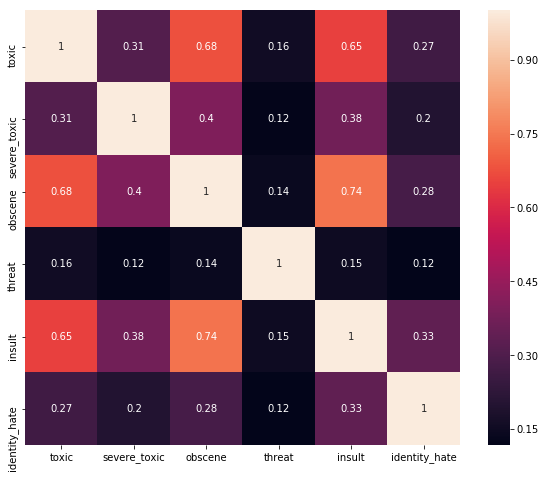

In [117]:
# correlation matrix between features
f, ax = plt.subplots(figsize=(10, 8))
corr = train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            square=True, ax=ax, annot=True)

In [ ]:
"""this function receives comments and returns clean word-list
  split words by whitespace, remove punctuations, change letters to lower case, 
  remove words that are not alphanumeric, remove 1-letter words
"""
def pre_process(word_text):
    tokens = word_text.split()
    table = str.maketrans({key: None for key in string.punctuation})
    tokens = [token.translate(table) for token in tokens]
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if len(token) > 1]
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token,"v") for token in tokens]
    sentence = ' '.join(tokens)
    return sentence

In [86]:
"""clean comment_text from the training set and testing set"""
train_comment_text = train.comment_text.copy()
valid_comment_text = valid.comment_text.copy()
test_comment_text = test.comment_text.copy()

train_text_processed = [pre_process(comment) for comment in train_comment_text]
valid_text_processed = [pre_process(comment) for comment in valid_comment_text]
test_text_processed = [pre_process(comment) for comment in test_comment_text]

In [87]:
print('The 0th comment text in unprocessed training set:')
print(train_comment_text.iloc[0])
print('\n')
print('The 0th comment text in clean training set:')
print(train_text_processed[0])
print('\n')
print('The 0th comment text in unprocessed validation set:')
print(valid_comment_text.iloc[0])
print('\n')
print('The 0th comment text in clean validation set:')
print(valid_text_processed[0])
print('\n')
print('The 0th comment text in unprocessed test set:')
print(test_comment_text.iloc[0])
print('\n')
print('The 0th comment text in clean test set:')
print(test_text_processed[0])

The 0th comment text in unprocessed training set:
"
 Oppose. WP:MOSTM, the guideline covering trademarks and brands, explicitly states not to do this. We don't need articles with titles like REALTOR, TIME, Se7en, Alien³, etc., despite those being their ""official"" names: these are brandings, and are designed to promote their products. But Wikipedia is not supposed to be promotional. NBC, CBS, and ABC are actual abbreviations, and are pronounced en-bee-cee, cee-bee-ess, ay-bee-cee. A reader who is truly unfamiliar with Fox in this context will end up pronouncing it ""eff-oh-ecks"".  "


The 0th comment text in clean training set:
oppose wpmostm guideline cover trademark brand explicitly state dont need article title like realtor time etc despite official name brand design promote products wikipedia suppose promotional nbc cbs abc actual abbreviations pronounce enbeecee ceebeeess aybeecee reader truly unfamiliar fox context end pronounce effohecks


The 0th comment text in unprocessed v

In [91]:
df_train = pd.DataFrame(data={"comment_text": train_text_processed})
df_train.to_csv("dataset/cleaned_train.csv", sep=',',index=False)

df_valid = pd.DataFrame(data={"comment_text": valid_text_processed})
df_valid.to_csv("dataset/cleaned_valid.csv", sep=',',index=False)

df_test = pd.DataFrame(data={"comment_text": test_text_processed})
df_test.to_csv("dataset/cleaned_test.csv", sep=',',index=False)

### Loading clean data, tokenizing and embedding

In [111]:
# Loading clean data
clean_train = pd.read_csv("dataset/cleaned_train.csv").fillna('')
clean_valid = pd.read_csv("dataset/cleaned_valid.csv").fillna('')
clean_test = pd.read_csv("dataset/cleaned_test.csv").fillna('')

clean_train_wordlist = clean_train.values.tolist()
clean_valid_wordlist = clean_valid.values.tolist()

clean_test_wordlist = clean_test.values.tolist()

In [114]:
# Tokenize and Pad

# Create tokenizer
tokenizer = Tokenizer()

# Fit and run tokenizer
tokenizer.fit_on_texts(train_text_processed + valid_text_processed  + test_text_processed)
tokenized_train = tokenizer.texts_to_sequences(train_text_processed)
tokenized_valid = tokenizer.texts_to_sequences(valid_text_processed)
tokenized_test = tokenizer.texts_to_sequences(test_text_processed)
word_index = tokenizer.word_index

# Extract variables
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in tokenized_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in tokenized_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))
print()

# Pad sequences
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')
processed_X_valid = pad_sequences(tokenized_valid, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

# Sample tokenization
for sample_i, (sent, token_sent) in enumerate(zip(train_text_processed[:2], tokenized_train[:2])):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

Vocab size: 287514
Longest comment size: 1250
Average comment size: 33.820049427407845
Stdev of comment size: 51.838657680743566
Max comment size: 189

Sequence 1
  Input:  oppose wpmostm guideline cover trademark brand explicitly state dont need article title like realtor time etc despite official name brand design promote products wikipedia suppose promotional nbc cbs abc actual abbreviations pronounce enbeecee ceebeeess aybeecee reader truly unfamiliar fox context end pronounce effohecks
  Output: [539, 39636, 959, 424, 4225, 1988, 1626, 62, 15, 26, 1, 197, 10, 29461, 25, 224, 894, 412, 29, 1988, 854, 674, 1919, 4, 486, 1790, 7128, 4914, 4019, 553, 8236, 2405, 108996, 108997, 108998, 801, 1253, 4332, 2305, 554, 239, 2405, 108999]
Sequence 2
  Input:  glen love fag
  Output: [8144, 291, 644]


The data representation for our vocabulary is one-hot encoding where every word is transformed into a vector with a 1 in its corresponding location. For example, if our word vector is [hi, how, are, you] and the word we are looking at is "you", the input vector for "you" would just be [0, 0, 0, 1]. This works fine unless our vocabulary is huge - in this case, 210,000 - which means we would end up with word vectors that consist mainly of a bunch of 0s.

Instead, we can use a Word2Vec technique to find continuous embeddings for our words. Here, we'll be using the pretrained FastText embeddings from Facebook to produce a 300-dimension vector for each word in our vocabulary.

P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, Enriching Word Vectors with Subword Information

The benefit of this continuous embedding is that words with similar predictive power will appear closer together on our word vector. The downside is that this creates more of a black box where the words with the most predictive power get lost in the numbers.

#### Fasttext

In [ ]:
embedding_dim = 300

# Get embeddings
embeddings_index = {}
f = open('wiki.en.vec', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

In [ ]:
# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
# Save embeddings
import h5py
with h5py.File('embeddings.h5', 'w') as hf:
    hf.create_dataset("fasttext",  data=embedding_matrix)

In [ ]:
# Load embeddings
with h5py.File('embeddings.h5', 'r') as hf:
    embedding_matrix = hf['fasttext'][:]